#### BASE

In [53]:
import numpy as np
from numba import cuda
import matplotlib.pyplot as plt
import math
import time

@cuda.jit
def RGB2HSV(rgb_in, h_out, s_out, v_out):
    tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    tidy = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y

    if tidx < rgb_in.shape[1] and tidy < rgb_in.shape[0]:
        # Preparation
        # GATHER: gather value into 3 arrays
        ## Scale R, G, B to [0..255] to [0..1]
        r = rgb_in[tidy, tidx, 0] / 255.0
        g = rgb_in[tidy, tidx, 1] / 255.0
        b = rgb_in[tidy, tidx, 2] / 255.0
        ## Find max and min among R, G, B ∈[0..1]
        cmax = max(r, max(g, b))
        cmin = min(r, min(g, b))
        ## ∆ = max−min
        diff = cmax - cmin
        
        # Calculate Hue
        if diff == 0: h = 0
        if cmax == r: h = (60 * ((g - b) / diff) % 6) 
        if cmax == g: h = (60 * ((b - r) / diff + 2))
        if cmax == b: h = (60 * ((r - g) / diff + 4))
        # Calculate Saturation
        s = 0 if cmax == 0 else (diff / cmax)
        # Calculate Value
        v = cmax
        
        # SCATTER: Write results to separate arrays
        h_out[tidy, tidx] = h
        s_out[tidy, tidx] = s
        v_out[tidy, tidx] = v


def convert_rgb_to_hsv(rgb_image):
    # Create output arrays
    height= rgb_image.shape[0]
    width = rgb_image.shape[1]
    h_out = np.zeros((height, width), dtype=np.float32)
    s_out = np.zeros((height, width), dtype=np.float32)
    v_out = np.zeros((height, width), dtype=np.float32)
    # CPU to GPU
    d_rgb = cuda.to_device(rgb_image)
    d_h = cuda.to_device(h_out)
    d_s = cuda.to_device(s_out)
    d_v = cuda.to_device(v_out)
    # CPU set up grid and block dimensions
    block_dim = (16, 16)
    grid_dim = (
        (width + block_dim[0] - 1) // block_dim[0],
        (height + block_dim[1] - 1) // block_dim[1]
    )
    # GPU launch kernel
    RGB2HSV[grid_dim, block_dim](d_rgb, d_h, d_s, d_v)
    # GPU to CPU
    h_out = d_h.copy_to_host()
    s_out = d_s.copy_to_host()
    v_out = d_v.copy_to_host()
    
    return h_out, s_out, v_out

#### RUN

Input image shape: (400, 600, 3)
Execution time with shared memory: 0.632 seconds


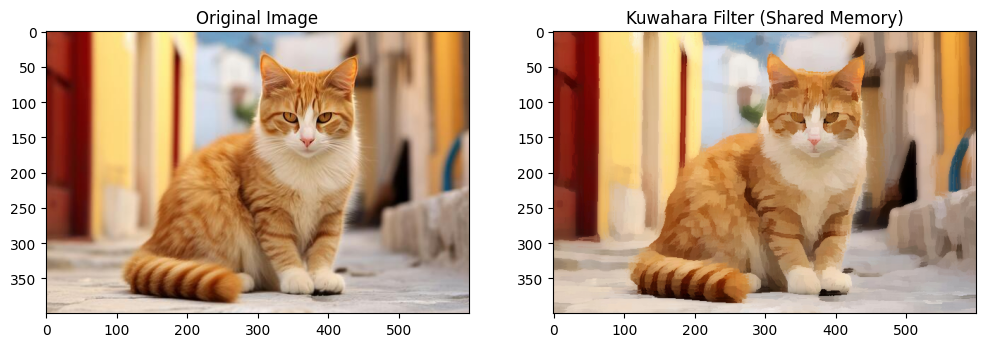

In [69]:
@cuda.jit
def kuwahara_filter_shared(rgb_in, h_in, s_in, v_in, rgb_out, window_size):
    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    bx = cuda.blockIdx.x
    by = cuda.blockIdx.y

    block_width = cuda.blockDim.x
    block_height = cuda.blockDim.y

    tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    tidy = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y   

    # if tidx >= width or tidy >= height:
    #     return

    height, width = rgb_in.shape[0], rgb_in.shape[1]

    shared_dim = block_width + 2 * window_size  # For each thread/pixel we need the neighborhood, so TILE_DIM = BLOCK_SIZE + 2 * window_size
    
    # Shared memory
    check = 32
    shared_rgb = cuda.shared.array(shape=(check, check, 3), dtype=np.float32)
    shared_v = cuda.shared.array(shape=(check, check), dtype=np.float32)

    # FOR EACH PIXEL: Load data into shared memory
    for dy in range(0, shared_dim, block_height):
        for dx in range(0, shared_dim, block_width):
            shared_y = ty + dy
            shared_x = tx + dx
            global_y = tidy - window_size + dy
            global_x = tidx - window_size + dx

            if (global_y >= 0 and global_y < height and
                global_x >= 0 and global_x < width):
                shared_rgb[shared_y, shared_x, 0] = rgb_in[global_y, global_x, 0]  # R
                shared_rgb[shared_y, shared_x, 1] = rgb_in[global_y, global_x, 1]  # G
                shared_rgb[shared_y, shared_x, 2] = rgb_in[global_y, global_x, 2]  # B
                shared_v[shared_y, shared_x] = v_in[global_y, global_x]
            else:
                shared_rgb[shared_y, shared_x, 0] = 0.0
                shared_rgb[shared_y, shared_x, 1] = 0.0
                shared_rgb[shared_y, shared_x, 2] = 0.0
                shared_v[shared_y, shared_x] = 0.0

    cuda.syncthreads()

    if tidx < width and tidy < height:
        means = cuda.local.array((4, 3), dtype=np.float32) 
        variances = cuda.local.array(4, dtype=np.float32)

        for quadrant in range(4):
            sum_R = 0.0
            sum_G = 0.0
            sum_B = 0.0
            sum_v = 0.0
            sum_v_squared = 0.0
            count = 0

            shared_x = tx + window_size
            shared_y = ty + window_size

            if quadrant == 0:  
                x_start, x_end = shared_x - window_size, shared_x + 1
                y_start, y_end = shared_y - window_size, shared_y + 1
            if quadrant == 1:
                x_start, x_end = shared_x, shared_x + window_size + 1
                y_start, y_end = shared_y - window_size, shared_y + 1
            if quadrant == 2:
                x_start, x_end = shared_x - window_size, shared_x + 1
                y_start, y_end = shared_y, shared_y + window_size + 1
            if quadrant == 3:
                x_start, x_end = shared_x, shared_x + window_size + 1
                y_start, y_end = shared_y, shared_y + window_size + 1

            for yi in range(y_start, y_end):
                for xi in range(x_start, x_end):
                    count += 1
                    r = shared_rgb[yi, xi, 0]
                    g = shared_rgb[yi, xi, 1]
                    b = shared_rgb[yi, xi, 2]
                    v = shared_v[yi, xi]

                    sum_R += r
                    sum_G += g
                    sum_B += b
                    sum_v += v
                    sum_v_squared += v * v

            means[quadrant, 0] = sum_R / count
            means[quadrant, 1] = sum_G / count
            means[quadrant, 2] = sum_B / count
            mean_v = sum_v / count
            variances[quadrant] = (sum_v_squared / count) - (mean_v * mean_v)

        min_var = variances[0]
        min_idx = 0
        for quadrant in range(1, 4):
            if variances[quadrant] < min_var:
                min_var = variances[quadrant]
                min_idx = quadrant

        rgb_out[tidy, tidx, 0] = means[min_idx, 0]
        rgb_out[tidy, tidx, 1] = means[min_idx, 1]
        rgb_out[tidy, tidx, 2] = means[min_idx, 2]


def apply_kuwahara_filter_shared(rgb_image, window_size=4):
    h, s, v = convert_rgb_to_hsv(rgb_image)
    
    # Prepare memory
    height, width = rgb_image.shape[0], rgb_image.shape[1]
    output = np.zeros_like(rgb_image)
    
    # CPU to GPU
    d_rgb = cuda.to_device(rgb_image)
    d_h = cuda.to_device(h)
    d_s = cuda.to_device(s)
    d_v = cuda.to_device(v)
    d_output = cuda.to_device(output)
    
    # Configuration: CPU asks GPU
    block_dim = (16, 16)
    grid_dim = (
        (width + block_dim[0] - 1) // block_dim[0],
        (height + block_dim[1] - 1) // block_dim[1]
    )
    
    # GPU processing
    kuwahara_filter_shared[grid_dim, block_dim](d_rgb, d_h, d_s, d_v, d_output, window_size)
    
    # GPU to CPU
    output = d_output.copy_to_host()
    
    return output

# Usage 
def kuwahara_usage_shared(window_size=4):
    # Load image
    image = plt.imread("image1.jpg")
    height, width = image.shape[:2]

    print("Input image shape:", image.shape)
    
    # Time the execution
    start = time.time()
    filtered_image = apply_kuwahara_filter_shared(image, window_size)
    end = time.time()
    print(f"Execution time with shared memory: {end - start:.3f} seconds")

    # Display results
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plt.imshow(image)
    plt.title('Original Image')
    plt.subplot(122)
    plt.imshow(filtered_image)
    plt.title('Kuwahara Filter (Shared Memory)')
    plt.show()

# Run the example
kuwahara_usage_shared(4)